# ISS-VSE CA1

In [19]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import imgaug as ia
from imgaug import augmenters as iaa
# from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

from CA1_Yolo import *
from voc import *
import xml.etree.ElementTree as ET
from keras.utils import Sequence

### Read all image and VOC dataset

In [79]:
def read_annotation_files(image_dir, annnotation_dir):
    all_annotations = []
    labels = {}
    for anno in sorted(os.listdir(annnotation_dir)):
        img = {'object':[]}
        try:
            xml_tree = ET.parse(annnotation_dir + anno)
        except Exception as ex:
            print(ex)
            print(f'Error parsing annotation xml: {annnotation_dir + anno}')
            continue
        for elem in xml_tree.iter():
            if 'filename' in elem.tag:
                img['filename'] = image_dir + elem.text
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag:
                obj = {}
                for attribute in list(elem):
                    if 'name' in attribute.tag:
                        obj['name'] = attribute.text
                        if obj['name'] in labels:
                            labels[obj['name']] += 1
                        else:
                            labels[obj['name']] = 1
                        img['object'] += [obj]
                    if 'bndbox' in attribute.tag:
                        for dim in list(attribute):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))
        if len(img['object']) > 0:
            bb_list = []
            for obj in img['object']:
                bb_list.append(ia.BoundingBox(x1=obj['xmin'], y1=obj['ymin'], x2=obj['xmax'], y2=obj['ymax'], label=obj['name']))
            img['bbs'] = ia.BoundingBoxesOnImage(bb_list, shape=(img['width'], img['height']))
            all_annotations += [img]
    return all_annotations, labels

In [63]:
#Reference https://www.kaggle.com/mpalermo/keras-pipeline-custom-generator-imgaug
class DataGenerator(Sequence):
    '''Generate data with augmentations using Keras Util Sequence API
        Required Methods:
        def __init__(self)
        def __len__(self)
        def on_epoch_end(self)
        def __getitem__(self)'''

    def __init__(self, image_path, labels, batch_size=32, image_dims=(416, 416, 3), shuffle=False, augment=True):
        self.image_path=image_path
        self.labels=labels
        self.batch_size=batch_size
        self.image_dims=image_dims
        self.shuffle=shuffle
        self.augment=augment
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.image_path)/self.batch_size))
    
    def on_epoch_end(self):
        '''Update index after each epoch'''
        self.index = np.arange(len(self.image_path))
        if self.shuffle:
            np.random.shuffle(self.index)
    
    def augment_with_bb(self, images, boundingbox):
        seq = iaa.Sequential([
            iaa.Fliplr(0.5)
        ])
        return seq.augment_images(images)
    
    def __getitems__(self, index):
        pass

In [80]:
trainimgfolder = "../data/image/"
trainannotatefolder = "../data/annotation/"
train_ints, labels = read_annotation_files(trainimgfolder, trainannotatefolder)
labels_unqiue = labels.keys()

In [82]:
train_ints[0]

{'object': [{'name': 'car',
   'xmin': 212,
   'ymin': 403,
   'xmax': 485,
   'ymax': 499},
  {'name': 'car', 'xmin': 550, 'ymin': 416, 'xmax': 629, 'ymax': 446},
  {'name': 'car', 'xmin': 634, 'ymin': 413, 'xmax': 721, 'ymax': 449},
  {'name': 'car', 'xmin': 718, 'ymin': 408, 'xmax': 896, 'ymax': 451},
  {'name': 'car', 'xmin': 1157, 'ymin': 357, 'xmax': 1280, 'ymax': 526}],
 'filename': '../data/image/b001.jpg',
 'width': 1280,
 'height': 720,
 'bbs': BoundingBoxesOnImage([BoundingBox(x1=212.0000, y1=403.0000, x2=485.0000, y2=499.0000, label=car), BoundingBox(x1=550.0000, y1=416.0000, x2=629.0000, y2=446.0000, label=car), BoundingBox(x1=634.0000, y1=413.0000, x2=721.0000, y2=449.0000, label=car), BoundingBox(x1=718.0000, y1=408.0000, x2=896.0000, y2=451.0000, label=car), BoundingBox(x1=1157.0000, y1=357.0000, x2=1280.0000, y2=526.0000, label=car)], shape=(1280, 720))}

In [83]:
# seq = iaa.Sequential([
#     iaa.Multiply((1.2, 1.5)), # change brightness, doesn't affect BBs
#     iaa.Affine(
#         translate_px={"x": 40, "y": 60},
#         scale=(0.5, 0.7)
#     ) # translate by 40/60px on x/y axis, and scale to 50-70%, affects BBs
# ])

seq = iaa.Sequential([
    iaa.AdditiveGaussianNoise(scale=0.05*255),
    iaa.Affine(translate_px={"x": (1, 5)})
])

In [89]:
imgs = [] 
imgs.append(cv2.imread(train_ints[0]['filename']))
imgs.append(cv2.imread(train_ints[1]['filename']))
img_aug, bbs_aug = seq(images=imgs, bounding_boxes=[train_ints[0]['bbs'], train_ints[1]['bbs']])

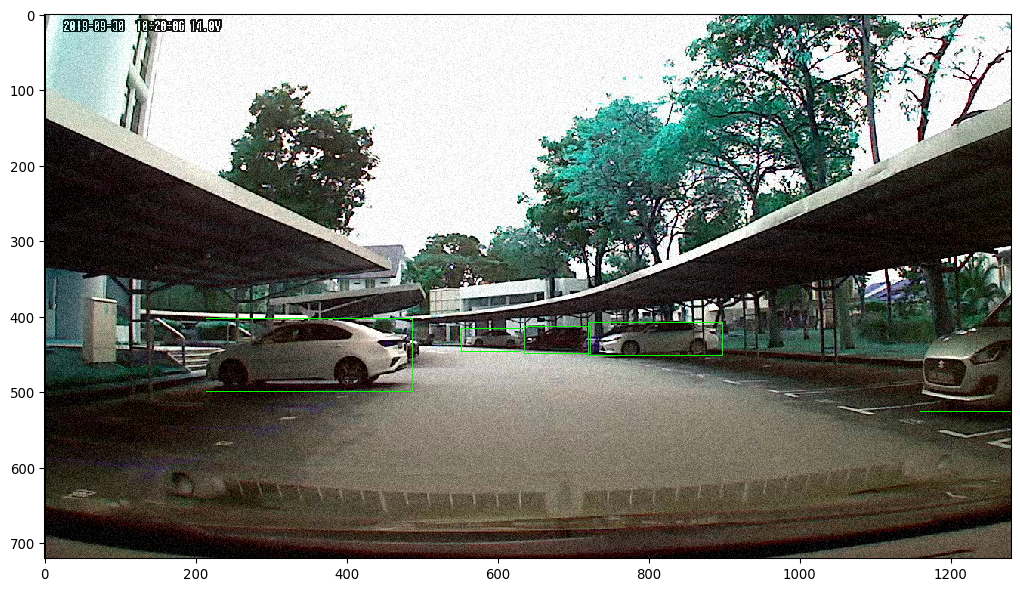

In [92]:
ia.imshow(bbs_aug[0].draw_on_image(img_aug[0]))


In [3]:
def read_voc(xml_file: str):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    list_with_all_boxes = []
    for boxes in root.iter('object'):
        filename = root.find('filename').text
        ymin, xmin, ymax, xmax = None, None, None, None
        for box in boxes.findall("bndbox"):
            ymin = int(box.find("ymin").text)
            xmin = int(box.find("xmin").text)
            ymax = int(box.find("ymax").text)
            xmax = int(box.find("xmax").text)
        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)
    return filename, list_with_all_boxes

In [17]:
# trainimgfolder = 'D:\\Workspace\\GitHub\\keras-yolo3\\data\\old_annotated_416x416\\'
# trainannotatefolder = 'D:\\Workspace\\GitHub\\keras-yolo3\\data\\old_raw_416x416\\'
trainimgfolder = "../data/image/"
trainannotatefolder = "../data/annotation/"
cache = 'D:\Workspace\GitHub\ISS-VSE-2019-09-23-IS1FT-CA1\data\cached'
labels = ['car','bus']
train_ints, train_labels = parse_voc_annotation(trainannotatefolder, trainimgfolder, cache, labels)

In [18]:
max_box_per_image = max([len(inst['object']) for inst in (train_ints)])
max_box_per_image

5

In [16]:
ann = os.listdir(trainannotatefolder)
ann[0]

'b001.xml'

In [56]:
tree = ET.parse(trainannotatefolder+ann[4])

In [57]:
tree

In [58]:
seen_labels = {}
img = {'object':[]}
for elem in tree.iter():
    if 'filename' in elem.tag:
        img['filename'] = trainimgfolder + elem.text
    if 'width' in elem.tag:
        img['width'] = int(elem.text)
    if 'height' in elem.tag:
        img['height'] = int(elem.text)
    if 'object' in elem.tag or 'part' in elem.tag:
        obj = {}

        for attr in list(elem):
            if 'name' in attr.tag:
                obj['name'] = attr.text

                if obj['name'] in seen_labels:
                    seen_labels[obj['name']] += 1
                else:
                    seen_labels[obj['name']] = 1

                if len(labels) > 0 and obj['name'] not in labels:
                    break
                else:
                    img['object'] += [obj]

            if 'bndbox' in attr.tag:
                for dim in list(attr):
                    if 'xmin' in dim.tag:
                        obj['xmin'] = int(round(float(dim.text)))
                    if 'ymin' in dim.tag:
                        obj['ymin'] = int(round(float(dim.text)))
                    if 'xmax' in dim.tag:
                        obj['xmax'] = int(round(float(dim.text)))
                    if 'ymax' in dim.tag:
                        obj['ymax'] = int(round(float(dim.text)))

In [59]:
seen_labels

{'car': 5}

In [60]:
img

{'object': [{'name': 'car',
   'xmin': 109,
   'ymin': 399,
   'xmax': 448,
   'ymax': 524},
  {'name': 'car', 'xmin': 561, 'ymin': 418, 'xmax': 647, 'ymax': 443},
  {'name': 'car', 'xmin': 650, 'ymin': 417, 'xmax': 743, 'ymax': 448},
  {'name': 'car', 'xmin': 769, 'ymin': 405, 'xmax': 943, 'ymax': 473},
  {'name': 'car', 'xmin': 435, 'ymin': 405, 'xmax': 499, 'ymax': 477}],
 'filename': 'D:\\Workspace\\GitHub\\ISS-VSE-2019-09-23-IS1FT-CA1\\data\\image\\b005.jpg',
 'width': 1280,
 'height': 720}

In [30]:
TESt = img.copy()

In [31]:
TESt += [img]

TypeError: unsupported operand type(s) for +=: 'dict' and 'list'

In [34]:
allinst = []
allinst += [img]
allinst += [img]

In [35]:
allinst

[{'object': [{'name': 'car',
    'xmin': 212,
    'ymin': 403,
    'xmax': 485,
    'ymax': 499},
   {'name': 'car', 'xmin': 550, 'ymin': 416, 'xmax': 629, 'ymax': 446},
   {'name': 'car', 'xmin': 634, 'ymin': 413, 'xmax': 721, 'ymax': 449},
   {'name': 'car', 'xmin': 718, 'ymin': 408, 'xmax': 896, 'ymax': 451},
   {'name': 'car', 'xmin': 1157, 'ymin': 357, 'xmax': 1280, 'ymax': 526}],
  'filename': 'D:\\Workspace\\GitHub\\ISS-VSE-2019-09-23-IS1FT-CA1\\data\\image\\b001.jpg',
  'width': 1280,
  'height': 720},
 {'object': [{'name': 'car',
    'xmin': 212,
    'ymin': 403,
    'xmax': 485,
    'ymax': 499},
   {'name': 'car', 'xmin': 550, 'ymin': 416, 'xmax': 629, 'ymax': 446},
   {'name': 'car', 'xmin': 634, 'ymin': 413, 'xmax': 721, 'ymax': 449},
   {'name': 'car', 'xmin': 718, 'ymin': 408, 'xmax': 896, 'ymax': 451},
   {'name': 'car', 'xmin': 1157, 'ymin': 357, 'xmax': 1280, 'ymax': 526}],
  'filename': 'D:\\Workspace\\GitHub\\ISS-VSE-2019-09-23-IS1FT-CA1\\data\\image\\b001.jpg',
  '